In [3]:
%matplotlib ipympl

In [4]:
from impedance.models.circuits import CustomCircuit
from impedance.models.circuits.elements import element
import numpy as np
import scipy
import matplotlib.pyplot as plt
from impedance.visualization import plot_nyquist, plot_bode

In [5]:
#My written functions
def add_noise(z,err):
    #err is the relative SD from mean value
    z_with_noise=np.random.normal(np.real(z),err*np.abs(np.real(z)))+1j*np.random.normal(np.imag(z),err*np.abs(np.imag(z)))
    return z_with_noise

def give_weights(z,wt):
    if (wt=="mod"):
        return np.concatenate((np.abs(z),np.abs(z)))
    elif (wt=="prop"):
        return np.concatenate((np.real(z),np.imag(z)))
    elif (wt=="" or wt=="unit"):
        return np.ones(2*len(z))

def give_xylim(zin,z0):
        zin_real=np.real(zin)
        zin_imag=np.imag(zin)

        z0_real=np.real(z0)
        z0_imag=np.imag(z0)

        max_0=np.maximum(np.max(z0_real),np.max(-z0_imag))
        max_in=np.maximum(np.max(zin_real),np.max(-zin_imag))

        xylim=np.maximum(max_0,max_in)
        return xylim

def find_index_of_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [6]:
@element(num_params=4, units=["Ohm", "Ohm", "F", ""],overwrite=True)
def TLMilinNew(p,f):
    omega = 2 * np.pi * np.array(f)
    R1, R2, Q, alpha = p[0], p[1], p[2], p[3]
    t12=R1/R2
    Rion1=R1
    Rion2=R2
    wclin1=1/(Rion1*Q)
    wclin2=1/(Rion2*Q)
    S1=np.sqrt((1j*omega)**alpha/wclin1)
    S2=np.sqrt((1j*omega)**alpha/wclin2)
    
    Z = -(2*1j*R1/S1)*(((scipy.special.yv(1,-2*1j*t12*S2/(t12-1)))*(scipy.special.jv(0,-2*1j*S1/(t12-1))))-((scipy.special.jv(1,-2*1j*t12*S2/(t12-1)))*(scipy.special.yv(0,-2*1j*S1/(t12-1)))))/(((scipy.special.jv(1,-2*1j*t12*S2/(t12-1)))*(scipy.special.yv(1,-2*1j*S1/(t12-1))))-((scipy.special.yv(1,-2*1j*t12*S2/(t12-1)))*(scipy.special.jv(1,-2*1j*S1/(t12-1)))))
    
    return Z

@element(num_params=4, units=["Ohm", "Ohm", "F", ""],overwrite=True)
def TLMilinNewzert(p,f):
    omega = 2 * np.pi * np.array(f)
    R1, R2, Q, alpha = p[0], p[1], p[2], p[3]
    wclin1=1/(R1*Q)
    eps=R1/R2-1
    S=np.sqrt((1j*omega)**alpha/wclin1)
    Z=-2*R1*(np.exp(2*S)+1)**2/((eps*(S**2+1/2)*np.exp(2*S)+(-S-(1/4)*eps)*np.exp(4*S)+S-(1/4)*eps))

    return Z
@element(num_params=4, units=["Ohm", "Ohm", "F", ""],overwrite=True)
def TLMilinNewzertSecond(p,f):
    omega = 2 * np.pi * np.array(f)
    R1, R2, Q, alpha = p[0], p[1], p[2], p[3]
    wclin1=1/(R1*Q)
    eps=R1/R2-1
    S=np.sqrt((1j*omega)**alpha/wclin1)

    Z=2*R1*4*(np.exp(4*S)+2*np.exp(2*S)+1)*(np.exp(2*S)+1)*S/((((S**4+2*S**3+2*S**2+3/2*S+9/8)*eps**2+(-4*S**3-S)*eps-4*S**2)*np.exp(2*S)+((-S**4+2*S**3-2*S**2+3/2*S-9/8)*eps**2+(-4*S**3-S)*eps+4*S**2)*np.exp(4*S)+(-(1/8)*eps**2+S*eps+4*S**2)*np.exp(6*S)-4*S**2+S*eps+(1/8)*eps**2))
    
    return Z



In [1]:
def plotter_for_lin(freq,circuit0,zin1,zin2,zin3,circuitg1,circuitg2,circuitg3,wt):
    
    c0=circuit0
    z0=c0.predict(freq)
    cg1=circuitg1
    cg2=circuitg2
    cg3=circuitg3
    cf1=cg1.fit(freq,zin1,sigma=give_weights(zin1,wt),bounds=(0,[np.inf,np.inf,np.inf,1]))
    #print(cf1)
    cf2=cg2.fit(freq,zin2,sigma=give_weights(zin2,wt),bounds=(0,[np.inf,np.inf,np.inf,1]))
    cf3=cg3.fit(freq,zin3,sigma=give_weights(zin3,wt),bounds=(0,[np.inf,np.inf,np.inf,1]))
    #print(cg3)

    zf1=cf1.predict(freq)
    zf2=cf2.predict(freq)
    zf3=cf3.predict(freq)

    p0=c0.initial_guess
    R1_0=p0[0]
    R2_0=p0[1]
    Q_0=p0[2]
    alpha_0=p0[3]

    pg=cg1.initial_guess
    R1_g=pg[0]
    R2_g=pg[1]
    Q_g=pg[2]
    alpha_g=pg[3]   

    pf1=cg1.parameters_
    print("pf1",pf1)
    R1_f1=pf1[0]
    R2_f1=pf1[1]
    Q_f1=pf1[2]
    alpha_f1=pf1[3]


    pf2=cg2.parameters_
    print("pf2",pf2)
    R1_f2=pf2[0]
    R2_f2=pf2[1]
    Q_f2=pf2[2]
    alpha_f2=pf2[3]

    pf3=cf3.parameters_
    R1_f3=pf3[0]
    R2_f3=pf3[1]
    Q_f3=pf3[2]
    alpha_f3=pf3[3]

    linewidth=1
    linewidth_actual=1
    ticksize=6
    color_actual="red"
    color_noise1=[0,0.5,0]
    color_noise2=[0.2,0.4,0.2]
    color_noise3=[0,0.65,0.4]
    color_fitted1=[0,0,1]
    color_fitted2=[0.4,0.58,0.65]
    color_fitted3=[0,0.6,1]

    fig = plt.figure(f"Results at")
    fig.set_size_inches(10,6)
    
    #profile fit and profile original
    ax1=plt.subplot2grid((5,4),(1,0),rowspan=2,colspan=2)
    #ax1= fig.add_subplot(2,4,1)
    ax1.plot([0,1],[R1_f1,R2_f1],linewidth=linewidth,color=color_fitted1,label="Fitted 1")
    ax1.plot([0,1],[R1_f2,R2_f2],linewidth=linewidth,color=color_fitted2,label="Fitted 2")
    ax1.plot([0,1],[R1_f3,R2_f3],linewidth=linewidth,color=color_fitted3,label="Fitted 3")
    ax1.plot([0,1],[R1_0,R2_0],linewidth=linewidth_actual,color=color_actual,label="Actual")
    ax1.tick_params(labelsize=ticksize)
    # ax1.axvline(x=delta_0,ls="--",linewidth=0.6,color=color_actual)
    # ax1.axvline(x=delta_f1,ls="--",linewidth=0.6,color=color_fitted1)
    # ax1.axvline(x=delta_f2,ls="--",linewidth=0.6,color=color_fitted2)
    # ax1.axvline(x=delta_f3,ls="--",linewidth=0.6,color=color_fitted3)
    ax1.set_ylabel("R1 / R2 (Ω)")
    ax1.set_xlabel("δ")
    ax1.set_xmargin(0)
    ax1.legend()

    xylim=max(give_xylim(zin1,zf1),give_xylim(zin1,z0))

    if xylim%1000>=1:
        units="kΩ"
        factor=1000
    else:
        units="Ω"
        factor=1

    #nyquist plot 
    #ax2=fig.add_subplot(1,2,2)
    ax2=plt.subplot2grid((5,4),(1,2),colspan=2,rowspan=4)
    ax2.set_xlim(-0.2*xylim/factor,xylim/factor)
    ax2.set_ylim(-0.2*xylim/factor,xylim/factor)
    plot_nyquist(zin1/factor,ax=ax2,units=units,labelsize=10,fmt=".",color=color_noise1,ms=2,ticksize=ticksize)
    plot_nyquist(zin2/factor,ax=ax2,units=units,labelsize=10,fmt=".",color=color_noise2,ms=2,ticksize=ticksize)
    plot_nyquist(zin3/factor,ax=ax2,units=units,labelsize=10,fmt=".",color=color_noise3,ms=2,ticksize=ticksize)
    plot_nyquist(zf1/factor,ax=ax2,units=units,labelsize=10,fmt="",color=color_fitted1,linewidth=linewidth,ticksize=ticksize)
    plot_nyquist(zf2/factor,ax=ax2,units=units,labelsize=10,fmt="",color=color_fitted2,linewidth=linewidth,ticksize=ticksize)
    plot_nyquist(zf3/factor,ax=ax2,units=units,labelsize=10,fmt="",color=color_fitted3,linewidth=linewidth,ticksize=ticksize)
    plot_nyquist(z0/factor,ax=ax2,units=units,labelsize=10,fmt="",color=color_actual,linewidth=linewidth,ticksize=ticksize)
    #inset_for_nyquist_plot
    ax2_inset=ax2.inset_axes(bounds=[0.4,0.1,0.5,0.5])
    plot_nyquist(zin1/factor,ax=ax2_inset,units=units,labelsize=10,fmt=".",color=color_noise1,ms=2,ticksize=ticksize)
    plot_nyquist(zin2/factor,ax=ax2_inset,units=units,labelsize=10,fmt=".",color=color_noise2,ms=2,ticksize=ticksize)
    plot_nyquist(zin3/factor,ax=ax2_inset,units=units,labelsize=10,fmt=".",color=color_noise3,ms=2,ticksize=ticksize)
    plot_nyquist(zf1/factor,ax=ax2_inset,units=units,labelsize=10,fmt="",color=color_fitted1,linewidth=linewidth,ticksize=ticksize)    
    
    plot_nyquist(zf2/factor,ax=ax2_inset,units=units,labelsize=10,fmt="",color=color_fitted2,linewidth=linewidth,ticksize=ticksize)    
    
    plot_nyquist(zf3/factor,ax=ax2_inset,units=units,labelsize=10,fmt="",color=color_fitted3,linewidth=linewidth,ticksize=ticksize)    
    plot_nyquist(z0/factor,ax=ax2_inset,units=units,labelsize=10,fmt="",color=color_actual,linewidth=linewidth,ticksize=ticksize)
    
    f_c=1/(R1_0*Q_0)
    idx=find_index_of_nearest(freq,f_c)
    z_c=c0.predict([freq[idx]])

    xylim_inset=1.2*np.real(z_c)
    ax2_inset.set_xlim(0,xylim_inset/factor)
    ax2_inset.set_ylim(0,xylim_inset/factor)
    ax2_inset.set_xlabel("")
    ax2_inset.set_ylabel("")
    ax2.indicate_inset_zoom(ax2_inset)

    # ax2_inset1=ax2.inset_axes(bounds=[0.4,0.7,0.3,0.2])
    # plot_nyquist(zin1/factor,ax=ax2_inset1,units=units,labelsize=10,fmt=".",color=color_noise1,ms=2,ticksize=ticksize)
    # plot_nyquist(zin2/factor,ax=ax2_inset1,units=units,labelsize=10,fmt=".",color=color_noise2,ms=2,ticksize=ticksize)
    # plot_nyquist(zin3/factor,ax=ax2_inset1,units=units,labelsize=10,fmt=".",color=color_noise3,ms=2,ticksize=ticksize)
    # plot_nyquist(zf1/factor,ax=ax2_inset1,units=units,labelsize=10,fmt="",color=color_fitted1,linewidth=linewidth,ticksize=ticksize)    
    
    # plot_nyquist(zf2/factor,ax=ax2_inset1,units=units,labelsize=10,fmt="",color=color_fitted2,linewidth=linewidth,ticksize=ticksize)    
    
    # plot_nyquist(zf3/factor,ax=ax2_inset1,units=units,labelsize=10,fmt="",color=color_fitted3,linewidth=linewidth,ticksize=ticksize)    
    # plot_nyquist(z0/factor,ax=ax2_inset1,units=units,labelsize=10,fmt="",color=color_actual,linewidth=linewidth,ticksize=ticksize)
    
    # f_c=1/(1000*R1_0*Q_0)
    # idx=find_index_of_nearest(freq,f_c)
    # z_c=c0.predict([freq[idx]])

    # xlim_inset=np.real(z_c)
    # ylim_inset=-np.imag(z_c)
    # # ax2_inset1.set_xlim(xlim_inset/factor,1.01*xlim_inset/factor)
    # # ax2_inset1.set_ylim(ylim_inset/factor,1.01*xlim_inset/factor)
    # ax2_inset1.set_xlim(xlim_inset/factor,1.01*xlim_inset/factor)
    # ax2_inset1.set_ylim(ylim_inset/factor,ylim_inset/factor+1.01*xlim_inset/factor)
    # ax2_inset1.set_aspect("equal")
    # ax2_inset1.set_xlabel("")
    # ax2_inset1.set_ylabel("")
    # ax2.indicate_inset_zoom(ax2_inset1)

    #bode plots
    #ax3a=fig.add_subplot(2,4,5)
    #ax3b=fig.add_subplot(2,4,6)
    ax3a=plt.subplot2grid((5,4),(3,0),colspan=1,rowspan=2)
    ax3b=plt.subplot2grid((5,4),(3,1),colspan=1,rowspan=2)
    plot_bode(freq,zin1/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt=".",color=color_noise1,ms=2,ticksize=ticksize)
    plot_bode(freq,zin2/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt=".",color=color_noise2,ms=2,ticksize=ticksize)
    plot_bode(freq,zin3/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt=".",color=color_noise3,ms=2,ticksize=ticksize)
    plot_bode(freq,zf1/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt="",color=color_fitted1,linewidth=linewidth,ticksize=ticksize)
    plot_bode(freq,zf2/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt="",color=color_fitted2,linewidth=linewidth,ticksize=ticksize)
    plot_bode(freq,zf3/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt="",color=color_fitted3,linewidth=linewidth,ticksize=ticksize)
    plot_bode(freq,z0/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt="",color=color_actual,linewidth=linewidth,ticksize=ticksize)


    percent_err1=(p0-pf1)*100/(p0)
    percent_err2=(p0-pf2)*100/(p0)
    percent_err3=(p0-pf3)*100/(p0)

    p0_table=[R1_0,R2_0,Q_0,alpha_0]
    pf1_table=[R1_f1,R2_f1,Q_f1,alpha_f1]
    pf2_table=[R1_f2,R2_f2,Q_f2,alpha_f2]
    pf3_table=[R1_f3,R2_f3,Q_f3,alpha_f3]
    pg_table=[R1_g,R2_g,Q_g,alpha_g]

    percent_err_table1=percent_err1
    percent_err_table2=percent_err2
    percent_err_table3=percent_err3

    def make_values_for_table(arr):
        for i in range(0,len(arr)):
            arr[i]="{:.2e}".format(arr[i])
        return arr
    
    pf1_table=make_values_for_table(pf1_table)
    pf2_table=make_values_for_table(pf2_table)
    pf3_table=make_values_for_table(pf3_table)
    p0_table=make_values_for_table(p0_table)
    pg_table=make_values_for_table(pg_table)
    percent_err_table1=make_values_for_table(percent_err_table1)
    percent_err_table2=make_values_for_table(percent_err_table2)
    percent_err_table3=make_values_for_table(percent_err_table3)

    data =np.array([p0_table,pg_table,pf1_table,percent_err_table1,pf2_table,percent_err_table2,pf3_table,percent_err_table3])
    #cell_colors=[["blue","blue","blue","blue"],["green","green","green","green"]]
    
    
    ax4=plt.subplot2grid((5,4),(0,0),colspan=4,rowspan=1)
    ax4.set_axis_off()
    colwidth=np.full((8),0.1)
    pm_table=ax4.table(np.transpose(data),colLabels=["Actual","Guess","Fitted 1","% Error","Fitted 2","% Error","Fitted 3","% Error"],colWidths=colwidth,rowLabels=[f"R1 [Ω]","R2 [Ω]","Q [Fs^(1-α)]","α"],loc="center") 
    pm_table.auto_set_font_size(False)
    pm_table.set_fontsize(8)

    fig.tight_layout(pad=0.5)



In [4]:
initial_guess=[1.1,1,6.61e-4]
tlmilin=CustomCircuit(initial_guess=initial_guess,circuit='TLMilinNew')
tlmilin_zert=CustomCircuit(initial_guess=initial_guess,circuit='TLMilinNewzert')
tlmilin_zert_2=CustomCircuit(initial_guess=initial_guess,circuit='TLMilinNewzertSecond')

In [5]:
f_pred = np.logspace(4,-3,num=100)
tlmilin_pred = tlmilin.predict(f_pred)
tlmilin_zert_pred = tlmilin_zert.predict(f_pred)
tlmilin_zert_2_pred = tlmilin_zert_2.predict(f_pred)

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\impedance\models\circuits\circuits.py:145: UserWarning: Simulating circuit based on initial parameters
  warnings.warn("Simulating circuit based on initial parameters")
C:\Users\admin\AppData\Local\Temp\ipykernel_1664\3184444182.py:13: RuntimeWarning: divide by zero encountered in divide
  Z = -(2*1j*R1/S1)*(((scipy.special.yv(1,-2*1j*t12*S2/(t12-1)))*(scipy.special.jv(0,-2*1j*S1/(t12-1))))-((scipy.special.jv(1,-2*1j*t12*S2/(t12-1)))*(scipy.special.yv(0,-2*1j*S1/(t12-1)))))/(((scipy.special.jv(1,-2*1j*t12*S2/(t12-1)))*(scipy.special.yv(1,-2*1j*S1/(t12-1))))-((scipy.special.yv(1,-2*1j*t12*S2/(t12-1)))*(scipy.special.jv(1,-2*1j*S1/(t12-1)))))
C:\Users\admin\AppData\Local\Temp\ipykernel_1664\3184444182.py:13: RuntimeWarning: invalid value encountered in divide
  Z = -(2*1j*R1/S1)*(((scipy.special.yv(1,-2*1j*t12*S2/(t12-1)))*(scipy.special.jv(0,-2*1j*S1

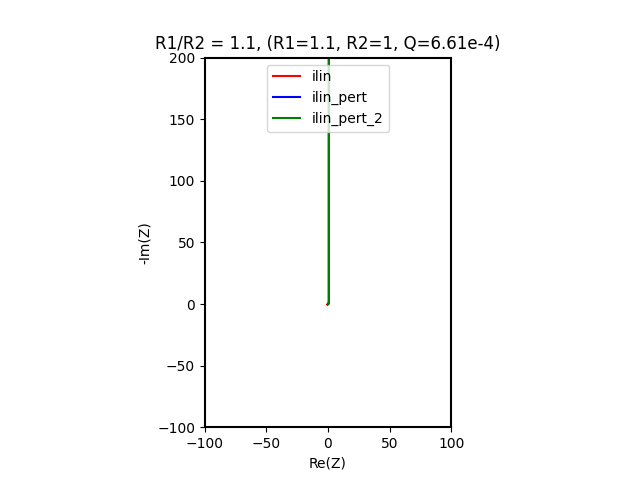

No such comm: 1d839d2da4734142b6a602c3de3284c6


In [6]:
plt.rcParams['axes.linewidth'] = 1.5
ax= plt.figure().add_subplot()
ax.set_title("R1/R2 = 1.1, (R1=1.1, R2=1, Q=6.61e-4)")
# # factor=194.56/1.5
factor=1
ax.plot(np.real(tlmilin_pred),-np.imag(tlmilin_pred),"r",label="ilin")
ax.plot(np.real(tlmilin_zert_pred),-np.imag(tlmilin_zert_pred),"b",label="ilin_pert")
ax.plot(np.real(tlmilin_zert_2_pred),-np.imag(tlmilin_zert_2_pred),"g",label="ilin_pert_2")
#ax.plot(np.real(tlmlin_semi_pred)/factor,-np.imag(tlmlin_semi_pred)/factor,"g",label="lin_semi")
#ax.plot(np.real(tlmlin_mix_pred)/factor,-np.imag(tlmlin_mix_pred)/factor,"y",label="lin_mix")
#ax.plot(np.real(tlmlin_zert_21_pred)/factor,-np.imag(tlmlin_zert_21_pred)/factor,"pink",label="lin_pert_21")
#ax.plot(np.real(tlmlin_zert_22_pred)/factor,-np.imag(tlmlin_zert_22_pred)/factor,"g",label="lin_pert_22")
#ax.legend(loc="upper center",ncol=4,bbox_to_anchor=[0.5,-0.14])
ax.legend(loc="upper center")
ax.set_xlabel("Re(Z)")
ax.set_ylabel("-Im(Z)")
ax.set_aspect("equal")
ax.set_xlim(-100,100)
ax.set_ylim(-100,200)
plt.rcParams['axes.linewidth'] = 1

In [7]:
def give_chi_square(z1,z2):
    return np.sum((np.real(z1)-np.real(z2))**2), np.sum((np.imag(z1)-np.imag(z2))**2)

def give_chi_square_normalized(z1,z2):
    return np.sqrt((np.sum(((np.real(z1)-np.real(z2)))**2))/len(z1)), np.sqrt(np.sum((np.imag(z1)-np.imag(z2))**2)/len(z1))

def give_relative_errors(z1,z2):
    return np.sqrt((np.sum(((np.real(z1)-np.real(z2))/np.real(z2))**2))/len(z1)), np.sqrt(np.sum(((np.imag(z1)-np.imag(z2))/np.imag(z2))**2)/len(z1))



import pandas as pd

models=["ilin","ilin_pert","ilin_pert_2"]
R1R2_cases=[(100,1),(1.1,1),(2,1),(2.5,1),(3,1),(1,100),(1,1.1),(1,2),(1,2.5),(1,3)]
#R1R2_cases_re_and_im=[R1R2_cases,["Re","Im"]]
R1R2_cases=[f"{i[0]} by {i[1]}" for i in R1R2_cases]

index=[R1R2_cases,["Re","Im"]]
index=pd.MultiIndex.from_product(index)

SD_non_normal_df=pd.DataFrame(columns=models,index=index)
SD_normal_df=pd.DataFrame(columns=models,index=index)
relative_normal_df=pd.DataFrame(columns=models,index=index)


for i in R1R2_cases:
   
   xlsx = pd.ExcelFile(f"ilin_R1_by_R2 ({i})100.xlsx")
   zz_ilin=pd.read_excel(xlsx,sheet_name="ilin",header=None)
   zz_ilin=zz_ilin.to_numpy()
   zz_ilin=zz_ilin[0]+1j*zz_ilin[1]

   for j in models:
       zz=pd.read_excel(xlsx,sheet_name=j,header=None)
       zz=zz.to_numpy()
       zz=zz[0]+1j*zz[1]

       chi_sqr_non_normal=give_chi_square(zz,zz_ilin)
       SD_non_normal_df.at[i,j]=chi_sqr_non_normal

       chi_sqr_normal=give_chi_square_normalized(zz,zz_ilin)
       SD_normal_df.at[i,j]=chi_sqr_normal
       
       relative_normal=give_relative_errors(zz,zz_ilin)
       relative_normal_df.at[i,j]=relative_normal
       

#exwrite=pd.ExcelWriter("ilin fc by 100 to 5 Hz.xlsx")
#chi_sqr_non_normal_df.to_excel(exwrite,sheet_name="non-normalized")
#chi_sqr_normal_df.to_excel(exwrite,sheet_name="noramlized")

with pd.ExcelWriter(
    "ilin SD error fc by 100 to 5 Hz.xlsx",
    mode="w",
) as writer:
    SD_non_normal_df.to_excel(writer,sheet_name="non-normalized")
    SD_normal_df.to_excel(writer,sheet_name="noramlized")
    relative_normal_df.to_excel(writer,sheet_name="relative")

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\Users\admin\AppData\Local\Packages\Pytho

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


20


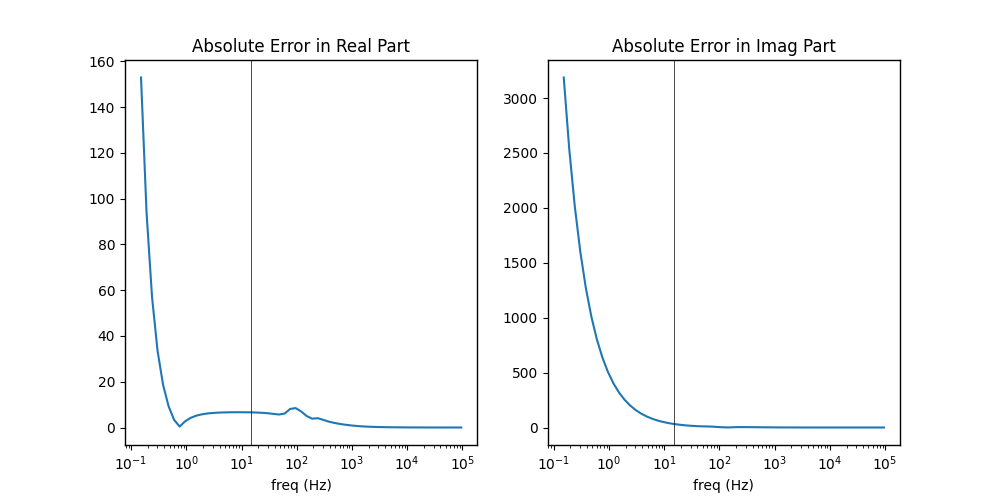

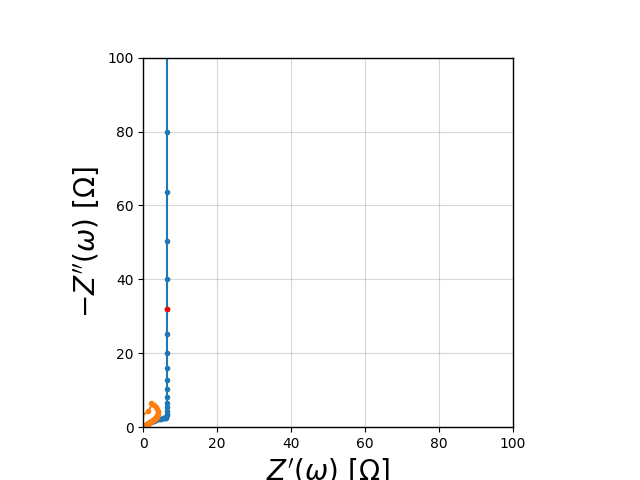

In [20]:
plt.close()
R1=100
R2=1

xlsx2 = pd.ExcelFile(f"ilin_R1_by_R2 ({R1} by {R2})100.xlsx")
zz_lin=pd.read_excel(xlsx2,sheet_name="ilin",header=None)
zz_lin_arr=zz_lin.to_numpy()
zz_lin=zz_lin_arr[0]+1j*zz_lin_arr[1]
zz_lin_freq=zz_lin_arr[2]

zz_lin_pert_22=pd.read_excel(xlsx2,sheet_name="ilin_pert_2",header=None)
zz_lin_pert_22_arr=zz_lin_pert_22.to_numpy()
zz_lin_pert_22=zz_lin_pert_22_arr[0]+1j*zz_lin_pert_22_arr[1]



#plot_nyquist(zz_lin,color="red")
#plot_nyquist(zz_lin_pert_22,color="blue")

r_err_real=np.abs(((np.real(zz_lin)-np.real(zz_lin_pert_22))/np.real(zz_lin)))

r_err_imag=np.abs(((np.imag(zz_lin)-np.imag(zz_lin_pert_22))/np.imag(zz_lin)))

a_err_real=np.abs(np.real(zz_lin)-np.real(zz_lin_pert_22))
a_err_imag=np.abs(np.imag(zz_lin)-np.imag(zz_lin_pert_22))

fig, [axx1, axx2]= plt.subplots(1,2)
# fig.("relative errors vs freq")
fig.set_size_inches(10,5)
#axx1.semilogx(zz_lin_freq,r_err_real,"red")
axx1.set_title("Absolute Error in Real Part")
axx1.semilogx(zz_lin_freq,a_err_real)
freq_c=1/(R1*6.61e-4)
axx1.axvline(freq_c,color="black",linewidth=0.5)
axx1.set_xlabel("freq (Hz)")

#axx2.semilogx(zz_lin_freq,r_err_imag,"red")
axx2.set_title("Absolute Error in Imag Part")
axx2.semilogx(zz_lin_freq,a_err_imag)
axx2.axvline(freq_c,color="black",linewidth=0.5)
axx2.set_xlabel("freq (Hz)")
plt.subplots_adjust()

def find_index_of_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

idx=find_index_of_nearest(zz_lin_freq,freq_c)

fig2, ax23=plt.subplots()
plot_nyquist(zz_lin,ax=ax23)
plot_nyquist(zz_lin_pert_22,ax=ax23)
plot_nyquist(zz_lin[idx],ax=ax23,color="red")
ax23.set_xlim(0,100)
ax23.set_ylim(0,100)

print(idx)